In [1]:
import matplotlib.pyplot as plt

20
(192, 192, 208)


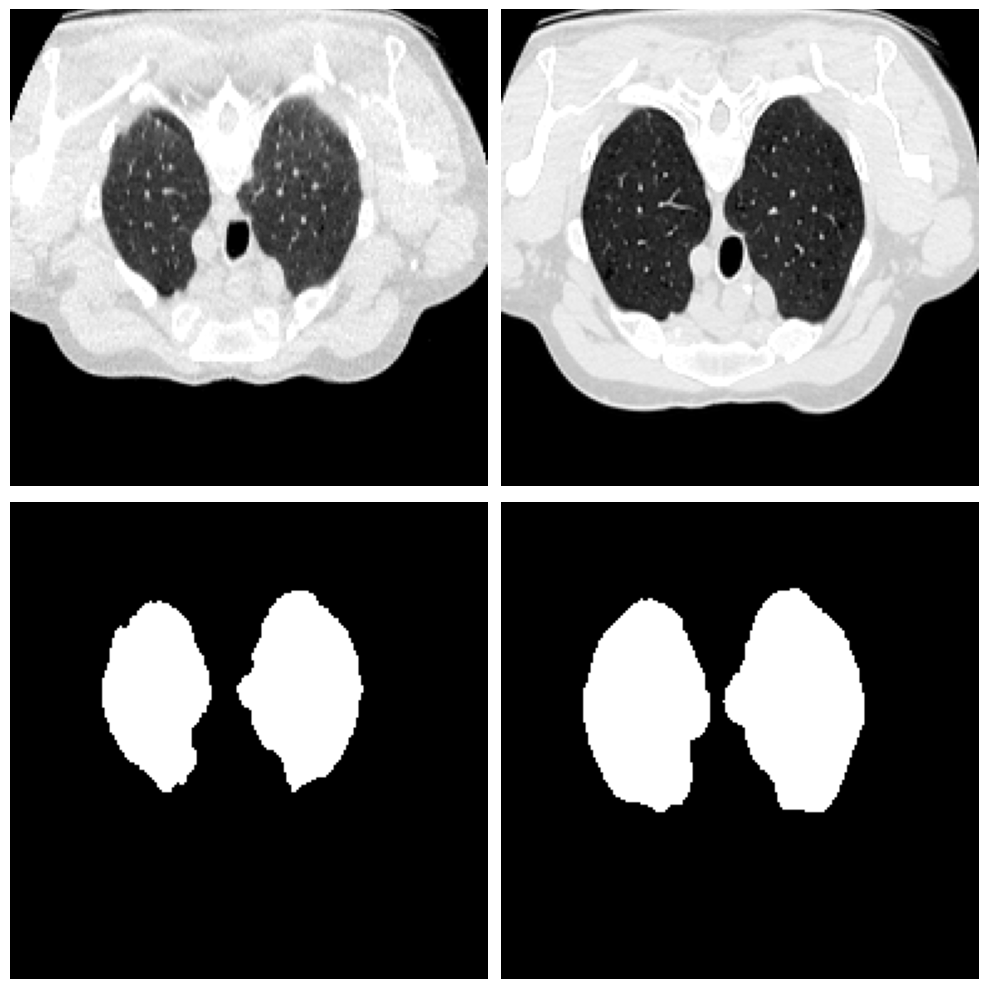

In [2]:
import sys 
sys.path.append('..')
from data_util.dataset import Data
from tools.utils         import show_img
from tools.visualization import plot_sample_data

import matplotlib.pyplot as plt
#if __name__  == 'main':
data_file = '/home/cerquinl/projects/raw_data/LungCT/LungCT_dataset.json'
root_dir  = '/home/cerquinl/projects/raw_data/LungCT/'


data      = Data(data_file, root_dir=root_dir, mode='train')
sample_id = 0
sample    = data[sample_id]
print(len(data))
plot_sample_data(sample, slide=150)

In [4]:
from tools.utils import to_numpy
from metrics.losses import compute_TRE
moving_kps = sample['kps1'][:,:]
fixed_kps  = sample['kps2'][:,:]
moving_img = sample['img2']
print(type(moving_kps), type(fixed_kps), type(moving_img))
moving_kps = to_numpy(moving_kps)
fixed_kps  = to_numpy(fixed_kps)
print(type(moving_kps), type(fixed_kps), type(moving_img))
print('Image Spacing',compute_TRE(moving_kps, fixed_kps, moving_img.GetSpacing()))
print('Spacing [1.75, 1.25, 1.75]', compute_TRE(moving_kps, fixed_kps, [1.75, 1.25, 1.75]))
print('Spacing [1, 1, 1]', compute_TRE(moving_kps, fixed_kps, [1., 1., 1.]))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'SimpleITK.SimpleITK.Image'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'SimpleITK.SimpleITK.Image'>
(20.05391491731027, 7.897901771320782)
(20.05391491731027, 7.897901771320782)
Sapacing [1, 1, 1] (14.415242826591285, 5.741956391904727)
